# Projeto Final - Análise de Gols em uma Partida de Futebol
Autor: Paulo Victor Lima |   Orientador : Sergio Lima Netto |    Universidade Federal do Rio de Janeiro - Escola Politécnica - Departamente de Engenharia Eletrônica e de Computação

## Importação das Bibliotecas

In [1407]:
# #Instalação das bibliotecas

# !pip install pandas
# # !pip install numpy
# # !pip install seaborn
# # !pip install matplotlib.pyplot
# # !pip install plotly.express
# # !pip install glob
# !pip install yellowbrick
# !pip install Scipy

In [1408]:
#Importação das bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import glob
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve
import seaborn as sns
from numpy import loadtxt
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import confusion_matrix
import time
from IPython.display import clear_output
from scipy.signal import medfilt
from cmath import sqrt
from numpy import argmax
from cProfile import label
from tkinter import OFF
from sklearn import metrics
from turtle import pos
from matplotlib import pyplot
from sklearn.metrics import RocCurveDisplay


## Importação Base de Dados

### Set Config

Classe set_config()

In [1409]:
class set_config():
    def __init__(self, match_generic_path, highlights_file_name):

        #Carrega as features a serem consideradas
        features_types = []
        features_types = loadtxt("..\config\Features_Types.dat", comments="#", delimiter='\n', dtype=str, ndmin=1)
        self.features_types = features_types

        ## Caminho padrão das partidas
        self.match_generic_path = match_generic_path

        # Nome Padrão arquivo "Highlights"
        self.highlights_file_name = highlights_file_name

set_config() para treinamentos

In [1410]:
def set_config_treinamento():
    
        match_generic_path = '..\\database\\Treinamento\\**\\'

        highlights_file_name = 'highlights.csv'
        
        return set_config(match_generic_path, highlights_file_name)

set_config() para testes

In [1411]:
def set_config_teste():
    
        match_generic_path = '..\\database\\Teste\\**\\'

        highlights_file_name = 'highlights.csv'
        
        return set_config(match_generic_path, highlights_file_name)

set_config() para todas as partidas

In [1412]:
def set_config_Aux():
    
        match_generic_path = '..\\database\\Teste_e_Treinamento\\**\\'

        highlights_file_name = 'highlights.csv'
        
        return set_config(match_generic_path, highlights_file_name)

In [1413]:
def set_feature_group_paths():
    grupo1 = "..\config\Grupos\Grupo1.dat"
    grupo2 = "..\config\Grupos\Grupo2.dat"
    grupo3 = "..\config\Grupos\Grupo3.dat"
    grupo4 = "..\config\Grupos\Grupo4.dat"
    grupo5 = "..\config\Grupos\Grupo5.dat"
    grupo6 = "..\config\Grupos\Grupo6.dat"
    grupo7 = "..\config\Grupos\Grupo7.dat"
    grupo8 = "..\config\Grupos\Grupo8.dat"
    grupo9 = "..\config\Grupos\Grupo9.dat"

    # feature_group_paths = [grupo1,grupo2,grupo3,grupo4,grupo5,grupo6,grupo7,grupo8,grupo9]
    feature_group_paths = [grupo8]

    return feature_group_paths

### Leitura Base de Dados

Definição das Funções de leitura da base de dados

In [1414]:
from itertools import count


counter=0

def import_moments_classifictaion(match, len, highlights_file_name):
    global counter
    
    #Caminho para os arquivos de features
    match_by_feature_path = match + highlights_file_name

    #Data frame com todos os intervalos de highligths de uma partida
    highlights_file =  pd.DataFrame()

    #nome das colunas do frame de highlights
    colnames=['first_frame','last_frame', 'classification'] 

    #Data Frame com todos os highlights de uma partida
    highlights_file = pd.read_csv(match_by_feature_path, names=colnames, index_col=None, sep =',', header=None)

    #Data frame com os intervalos de highligths de uma partida
    highlights_of_match = pd.DataFrame(list(range(1,len)), columns=['classification_perigo'], index=list(range(1,len)))

    highlights_of_match['classification_perigo'] = np.nan
    highlights_of_match['classification_gol'] = highlights_of_match['classification_perigo']
    highlights_of_match['frame_id'] = list(range(counter+1,counter+len))

    counter+=len    
    
    for index,row in highlights_file.iterrows():
        first_frame = int(row['first_frame']) if int(row['first_frame']) != ' ' else 0
        last_frame = int(row['last_frame']) if row['last_frame'] != ' ' else int(row['first_frame'])
        classification_perigo = 'Perigo' if (row['classification'] == ' Gol' or row['classification'] == ' Perigo' or row['classification'] == ' Muito Perigo' ) else 'Normal'
        classification_gol = 'Gol' if row['classification'] == ' Gol' else 'Não Gol'


        highlights_of_match.loc[first_frame:last_frame, ['classification_perigo','classification_gol']] = [classification_perigo,classification_gol]
        
    return highlights_of_match


In [1415]:
def import_database (set_config):

    from numpy import loadtxt

    #Carrega as features a serem consideradas
    features_types = []
    features_types = loadtxt("..\config\Features_Types.dat", comments="#", delimiter='\n', dtype=str, ndmin=1)

    ## Caminho padrão das partidas
    match_generic_path = set_config.match_generic_path

    #Lista de partidas existentes na base
    all_matches = glob.glob(match_generic_path, recursive = False)

    ## Data Frame com todos os momementos de todas as partidas
    all_moments = pd.DataFrame()
    ## Array de Data Frames com todos os Data Frames das partidas
    all_moments_array = []

    for match in all_matches:
        print(match)

        #Data frame com todos os momentos de uma partida
        moments_of_match=  pd.DataFrame()

        for feature in features_types:

            #Caminho para os arquivos de features
            match_by_feature_path = match + feature

            #Data Frame com todos os momentos de uma partida de uma feature especifica
            moments_of_match[feature] = pd.read_csv(match_by_feature_path, index_col=None, sep ='\n', thousands=r".", header=None)
        
        #Preenche a coluna 'Match' com a partida
        moments_of_match['Match'] = [match_by_feature_path.split('\\')[-2] for _ in range(len(moments_of_match[feature]))]

        moments_of_match[['Classification_Perigo','Classification_Gol','Frame_ID']] = import_moments_classifictaion(match, len(moments_of_match[feature]), set_config.highlights_file_name)  

        moments_of_match.dropna(axis=0, how='any',inplace=True)

        #Adiciona ao array de Data Frames o Data Frame gerado para a partida
        all_moments_array.append(moments_of_match)

    all_moments = pd.concat(all_moments_array,  sort=False, axis=0, ignore_index=True)


    all_moments.to_csv( set_config.match_generic_path.split('\\')[-3] + "moments.csv", index=False, sep=';')
    return all_moments

    

## Divisão Previsores e Classe

Previsores

In [1416]:
def get_predictors(all_moments, columns_names):
    return all_moments[columns_names].values

Classes

In [1417]:
def get_classes_perigo(all_moments):
    return all_moments['Classification_Perigo'].values

In [1418]:
def get_classes_gol(all_moments):
    return all_moments['Classification_Gol'].values

In [1419]:
def get_Second_Stage_Df(features_in_group, predictors_teste, classes_teste_perigo, predictions_perigo_after_filter, classes_teste_gol):
        df_predictor_teste = pd.DataFrame(predictors_teste)
        df_classes_teste_perigo = pd.DataFrame(classes_teste_perigo)
        df_predictions_perigo_after_filter = pd.DataFrame(np.array(predictions_perigo_after_filter))
        df_classes_teste_gol = pd.DataFrame(classes_teste_gol)

        df_second_stage_intermediary = pd.concat([df_predictor_teste, df_classes_teste_perigo, df_predictions_perigo_after_filter, df_classes_teste_gol], axis=1, ignore_index=True)

        column_names = ['Classification_Teste_Perigo', 'Prediction_Teste_Perigo', 'Classification_Gol']
        column_names = np.append(features_in_group, column_names)
        df_second_stage_intermediary.columns = column_names

        #Filtra Apenas os casos que foram classificados Corretamente no primeiro estágio
        df_second_stage_intermediary = df_second_stage_intermediary.loc[(df_second_stage_intermediary['Classification_Teste_Perigo'] == df_second_stage_intermediary['Prediction_Teste_Perigo'])]
        #Filtra Apenas os casos que foram classificados como Perigo no primeiro estágio
        return df_second_stage_intermediary.loc[(df_second_stage_intermediary['Classification_Teste_Perigo'] == 'Perigo')]

        

## Treinamento

In [1420]:
def teste_gol(N,predictorsTreinamento, classesTreinamento, predictorsTeste,threshold):
        ##Cria o Random Forest e realiza o teste
        random_forest = RandomForestClassifier(n_estimators=N,criterion='gini',random_state=0, class_weight="balanced")
        random_forest.fit(predictorsTreinamento, classesTreinamento)

        # predicted_proba = random_forest.predict_proba(predictorsTeste)

        # df_teste = pd.DataFrame(columns=['Gol', 'Não Gol'])

        # df_teste['Gol'] = predicted_proba[:,0]
        # df_teste['Não Gol'] = predicted_proba[:,1]

        # print(threshold)
        # predicted = (random_forest.predict_proba(predictorsTeste)[:,0] >= threshold).astype(int)

        # df_teste['Previsto'] = ['GOL' if x==1 else 'Não GOL' for x in medfilt(predicted,kernel_size=1)]
        
        # df_teste.to_csv( "..\\..\\Resultados Modelo\\Teste.csv", index=False, sep=';')

        
        predicted = (random_forest.predict_proba(predictorsTeste)[:,0] >= threshold).astype(int)
        # predicted = (random_forest.predict_proba(predictorsTeste)[:,0]).astype(int)
        return predicted


    

In [1421]:
def teste_perigo(N,predictorsTreinamento, classesTreinamento, predictorsTeste,threshold):
        ##Cria o Random Forest e realiza o teste
        random_forest = RandomForestClassifier(n_estimators=N,criterion='gini',random_state=0, class_weight="balanced")
        random_forest.fit(predictorsTreinamento, classesTreinamento)

        # predicted_proba = random_forest.predict_proba(predictorsTeste)

        # df_teste = pd.DataFrame(columns=['Normal', 'Perigo'])

        # df_teste['Normal'] = predicted_proba[:,0]
        # df_teste['Perigo'] = predicted_proba[:,1]

        # print(threshold)
        # predicted = (random_forest.predict_proba(predictorsTeste)[:,1] >= threshold).astype(int)

        # df_teste['Previsto'] = ['Perigo' if x==1 else 'Normal' for x in medfilt(predicted,kernel_size=1)]
        
        # df_teste.to_csv( "..\\..\\Resultados Modelo\\Teste.csv", index=False, sep=';')

        predicted = (random_forest.predict_proba(predictorsTeste)[:,1] >= threshold).astype(int)
        # predicted = (random_forest.predict_proba(predictorsTeste)[:,0]).astype(int)
        return predicted

## Curva Roc e Filtro de Mediana

### Filtro de Mediana

In [1422]:
def median_filter(predictions, classificacaoPositiva, classificacaoNegativa,WindowWidth):
    #Aplica o Filtro de Mediana

        return [classificacaoPositiva if x==1 else classificacaoNegativa for x in medfilt(predictions,kernel_size=WindowWidth)]
        # return [classificacaoPositiva if x==1 else classificacaoNegativa for x in medfilt(binary_preditction)]


In [1423]:
def median_filter_binary(predictions, WindowWidth):
    #Aplica o Filtro de Mediana
    return medfilt(predictions, kernel_size=WindowWidth)

### Curva Roc

In [1424]:
def roc_curve_plot_gol(N,predictorsTreinamento, classesTreinamento, predictorsTeste, classes_teste, classificacaoPositiva):

        ##Cria o Random Forest e realiza o teste
        random_forest = RandomForestClassifier(n_estimators=N,criterion='gini',random_state=0, class_weight="balanced")
        random_forest.fit(predictorsTreinamento, classesTreinamento)

        predictions = random_forest.predict_proba(predictorsTeste)[:,0]
        fpr, tpr, threshold = metrics.roc_curve(classes_teste, predictions,pos_label=classificacaoPositiva)
        auc = round(metrics.roc_auc_score(classes_teste, predictions), 4)

        major_ticks_x = np.arange(0, 1.01, 0.1)
        major_ticks_y = np.arange(0, 1.01, 0.05)
        minor_ticks = np.arange(0, 1, 0.05)
        plt.plot(threshold,tpr,label="Taxa de Verdadeiro Positivo")
        plt.plot(threshold,fpr,label="Taxa de Falso Positivo")
        # plt.plot(fpr,tpr,label="Curva Roc - Random Forest (AUC = " + str(auc)+")")
        plt.xticks(major_ticks_x)
        plt.yticks(major_ticks_y)
        plt.xlabel('False Positive Rate (Positive Label: Perigo)')
        plt.ylabel('True Positive Rate (Positive Label: Perigo)')
        plt.xlabel('Limiar')
        plt.ylabel('Taxa')
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.0])
        plt.legend()

  

In [1425]:
def roc_curve_plot_perigo(N,predictorsTreinamento, classesTreinamento, predictorsTeste, classes_teste, classificacaoPositiva):

        ##Cria o Random Forest e realiza o teste
        random_forest = RandomForestClassifier(n_estimators=N,criterion='gini',random_state=0, class_weight="balanced")
        random_forest.fit(predictorsTreinamento, classesTreinamento)

        predictions = random_forest.predict_proba(predictorsTeste)[:,1]
        fpr, tpr, threshold = metrics.roc_curve(classes_teste, predictions,pos_label=classificacaoPositiva)
        auc = round(metrics.roc_auc_score(classes_teste, predictions), 4)

        major_ticks_x = np.arange(0, 1.0, 0.1)
        major_ticks_y = np.arange(0, 1.0, 0.05)
        minor_ticks = np.arange(0, 1, 0.05)
        plt.plot(threshold,tpr,label="Taxa de Verdadeiro Positivo")
        plt.plot(threshold,fpr,label="Taxa de Falso Positivo")
        # plt.plot(fpr,tpr,label="Curva Roc - Random Forest (AUC = " + str(auc)+")")
        plt.xticks(major_ticks_x)
        plt.yticks(major_ticks_y)
        plt.xlabel('False Positive Rate (Positive Label: Perigo)')
        plt.ylabel('True Positive Rate (Positive Label: Perigo)')
        plt.xlabel('Limiar')
        plt.ylabel('Taxa')
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
        plt.xlim([0.0,1.0])
        plt.ylim([0,1.0])
        plt.legend()

  

In [1426]:
def multiple_roc_curve_plot(N,predictorsTreinamento, classesTreinamento, predictorsTeste, classes_teste, classificacaoPositiva, threshold):
        ##Cria o Random Forest e realiza o teste
        random_forest = RandomForestClassifier(n_estimators=N,criterion='gini',random_state=0, class_weight="balanced")
        random_forest.fit(predictorsTreinamento, classesTreinamento)

        predictions = random_forest.predict_proba(predictorsTeste)[:,0]
        fpr, tpr, threshold_second_stage = metrics.roc_curve(classes_teste, predictions,pos_label=classificacaoPositiva)
        # auc = round(metrics.roc_auc_score(classes_teste, predictions), 4)

        major_ticks_x = np.arange(0, 1, 0.1)
        major_ticks_y = np.arange(0, 1, 0.05)
        minor_ticks = np.arange(0, 1, 0.05)
        # plt.plot(fpr,tpr,label="Limiar Primeiro Estágio="+str(round(threshold, 2)))
        plt.plot(threshold_second_stage,tpr,label="Taxa de Verdadeiro Positivo"+str(round(threshold, 2)))
        # plt.plot(threshold_second_stage,fpr,label="Taxa de Falso Positivo"+str(round(threshold, 2)))
        plt.xticks(major_ticks_x)
        plt.yticks(major_ticks_y)
        # plt.xlabel('Taxa Falso Positivo (Classificação Positiva: Gol)')
        # plt.ylabel('Taxa Verdadeiro Positivo (Classificação Positiva: Gol)')
        plt.xlabel('Limiar')
        plt.ylabel('Taxa de Verdadeiro Positivo')
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
        plt.xlim([0.0,1.0])
        plt.ylim([0,1.0])
        plt.legend()

In [1427]:
def get_Results_Two_Stages_roc_curve(df_results, features_in_group, N, group_name, predictors_treinamento, classes_treinamento_perigo, classes_treinamento_gol, predictors_teste, classes_teste_perigo, classes_teste_gol):
        
        for threshold in np.arange(0.0,0.54,0.05):
                print(threshold)

                #######################################Primeiro Estágio####################################
                predictions_perigo = teste_perigo(N, predictors_treinamento, classes_treinamento_perigo, predictors_teste,threshold)
                predictions_perigo_after_filter =  median_filter(predictions_perigo, 'Perigo', 'Normal')
                df_second_stage = get_Second_Stage_Df(features_in_group, predictors_teste, classes_teste_perigo, predictions_perigo_after_filter, classes_teste_gol)
                

        #         #######################################Segundo Estágio####################################
                df_second_stage = get_Second_Stage_Df(features_in_group, predictors_teste, classes_teste_perigo, predictions_perigo_after_filter, classes_teste_gol)


                # Separa Preditores e Classificadores da base de teste
                predictors_teste_second_stage = get_predictors(df_second_stage,features_in_group)
                classes_teste_gol_second_stage = get_classes_gol(df_second_stage)

                multiple_roc_curve_plot(N, predictors_treinamento, classes_treinamento_gol, predictors_teste_second_stage,classes_teste_gol_second_stage,'Gol',threshold)
                

In [1428]:
def multiple_goal_rate_curve_plot(N,predictorsTreinamento, classesTreinamento, predictorsTeste, classes_teste, classificacaoPositiva, threshold):
        ##Cria o Random Forest e realiza o teste
        random_forest = RandomForestClassifier(n_estimators=N,criterion='gini',random_state=0, class_weight="balanced")
        random_forest.fit(predictorsTreinamento, classesTreinamento)
        

        predictions = random_forest.predict_proba(predictorsTeste)[:,0]
        predictions_gol = (predictions >= 0.5).astype(int)
        predictions_gol_after_filter =  median_filter(predictions_gol, 'Gol', 'Não Gol')


        #Verifica quantos gols foram previstos no primeiro estágio
        tp, fn, fp, tn = confusion_matrix(classes_teste, predictions_gol_after_filter).ravel()
        first_stage_predicted_goals = tp+fn
        first_stage_predicted_not_goals = tn+fp

        fpr, tpr, threshold_second_stage = metrics.roc_curve(classes_teste, predictions,pos_label=classificacaoPositiva)
        
        predicted_goals_rate = (first_stage_predicted_goals * tpr)/4217
        false_predicted_goals_rate = (first_stage_predicted_not_goals * fpr)/18614

        # print(predicted_goals_rate)

        major_ticks_x = np.arange(0, 1.01, 0.1)
        major_ticks_y = np.arange(0, 1.01, 0.05)
        minor_ticks = np.arange(0, 1, 0.05)
        # plt.plot(threshold_second_stage,predicted_goals_rate,label="Assertividade de Gols (Threshold Primeiro Estágio="+str(round(threshold, 2))+")")
        # plt.plot(threshold_second_stage,false_predicted_goals_rate,label="Total de Falso Positivos (Threshold Primeiro Estágio="+str(round(threshold, 2))+")")
        # plt.plot(false_predicted_goals_rate,predicted_goals_rate,label="Threshold Primeiro Estágio="+str(round(threshold, 2)))
        plt.plot(threshold_second_stage,false_predicted_goals_rate,label="Threshold Primeiro Estágio="+str(round(threshold, 2)))
        plt.xticks(major_ticks_x)
        plt.yticks(major_ticks_y)
        plt.ylabel('Falso Positivo Total')
        plt.xlabel('Limiar')
        # plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.0])
        plt.legend()

In [1429]:
def get_Two_Stages_total_goal_positive_rate(df_results, features_in_group, N, group_name, predictors_treinamento, classes_treinamento_perigo, classes_treinamento_gol, predictors_teste, classes_teste_perigo, classes_teste_gol):
        
        for threshold in np.arange(0.0,0.54,0.05):
        # for threshold in np.arange(0.15,0.19,0.05):
                print(threshold)

                #######################################Primeiro Estágio####################################
                predictions_perigo = teste_perigo(N, predictors_treinamento, classes_treinamento_perigo, predictors_teste,threshold)
                predictions_perigo_after_filter =  median_filter(predictions_perigo, 'Perigo', 'Normal')
                df_second_stage = get_Second_Stage_Df(features_in_group, predictors_teste, classes_teste_perigo, predictions_perigo_after_filter, classes_teste_gol)
                

        #         #######################################Segundo Estágio####################################
                df_second_stage = get_Second_Stage_Df(features_in_group, predictors_teste, classes_teste_perigo, predictions_perigo_after_filter, classes_teste_gol)


                # Separa Preditores e Classificadores da base de teste
                predictors_teste_second_stage = get_predictors(df_second_stage,features_in_group)
                classes_teste_gol_second_stage = get_classes_gol(df_second_stage)

                multiple_goal_rate_curve_plot(N, predictors_treinamento, classes_treinamento_gol, predictors_teste_second_stage,classes_teste_gol_second_stage,'Gol',threshold)
                

In [1430]:
def roc_curve_plot_gol_multiples_window_width(N,predictorsTreinamento, classesTreinamento, predictorsTeste, classes_teste, classificacaoPositiva):

    for window_width in np.arange(0,501,100):
        print(window_width)
        ##Cria o Random Forest e realiza o teste
        random_forest = RandomForestClassifier(n_estimators=N,criterion='gini',random_state=0, class_weight="balanced")
        random_forest.fit(predictorsTreinamento, classesTreinamento)

        predictions = random_forest.predict_proba(predictorsTeste)[:,0]
        predictions_after_mediand_filter = median_filter_binary(predictions, window_width+1)

        fpr, tpr, threshold = metrics.roc_curve(classes_teste, predictions_after_mediand_filter,pos_label=classificacaoPositiva)
        auc = round(metrics.roc_auc_score(classes_teste, predictions_after_mediand_filter), 4)

        major_ticks_x = np.arange(0, 1.01, 0.1)
        major_ticks_y = np.arange(0, 1.01, 0.05)
        minor_ticks = np.arange(0, 1, 0.05)
        # plt.plot(threshold,tpr,label="Taxa de Verdadeiro Positivo")
        # plt.plot(threshold,fpr,label="Taxa de Falso Positivo")
        plt.plot(fpr,tpr,label="Curva Roc - Random Forest (Tamanho da Janela = " + str(window_width+1)+")")
        plt.xticks(major_ticks_x)
        plt.yticks(major_ticks_y)
        plt.xlabel('False Positive Rate (Positive Label: Gol)')
        plt.ylabel('True Positive Rate (Positive Label: Gol)')
        # plt.xlabel('Limiar')
        # plt.ylabel('Taxa')
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
        plt.xlim([-0.01,1.01])
        plt.ylim([-0.01,1.01])
        plt.legend()
    

In [1431]:
def roc_curve_plot_perigo_multiples_window_width(N,predictorsTreinamento, classesTreinamento, predictorsTeste, classes_teste, classificacaoPositiva):

    for window_width in np.arange(0,201,50):
        print(window_width)
        ##Cria o Random Forest e realiza o teste
        random_forest = RandomForestClassifier(n_estimators=N,criterion='gini',random_state=0, class_weight="balanced")
        random_forest.fit(predictorsTreinamento, classesTreinamento)

        predictions = random_forest.predict_proba(predictorsTeste)[:,1]
        predictions_after_mediand_filter = median_filter_binary(predictions, window_width+1)

        fpr, tpr, threshold = metrics.roc_curve(classes_teste, predictions_after_mediand_filter,pos_label=classificacaoPositiva)
        auc = round(metrics.roc_auc_score(classes_teste, predictions_after_mediand_filter), 4)

        major_ticks_x = np.arange(0, 1.01, 0.1)
        major_ticks_y = np.arange(0, 1.01, 0.05)
        minor_ticks = np.arange(0, 1, 0.05)
        # plt.plot(threshold,tpr,label="Taxa de Verdadeiro Positivo")
        # plt.plot(threshold,fpr,label="Taxa de Falso Positivo")
        plt.plot(fpr,tpr,label="Curva Roc - Random Forest (Tamanho da Janela = " + str(window_width+1)+")")
        plt.xticks(major_ticks_x)
        plt.yticks(major_ticks_y)
        plt.xlabel('False Positive Rate (Positive Label: Perigo)')
        plt.ylabel('True Positive Rate (Positive Label: Perigo)')
        # plt.xlabel('Limiar')
        # plt.ylabel('Taxa')
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.0])
        plt.legend()
    

In [1432]:
def multiple_roc_curve_plot_median_filter(N,predictorsTreinamento, classesTreinamento, predictorsTeste, classes_teste, classificacaoPositiva, window_width):
        ##Cria o Random Forest e realiza o teste
        random_forest = RandomForestClassifier(n_estimators=N,criterion='gini',random_state=0, class_weight="balanced")
        random_forest.fit(predictorsTreinamento, classesTreinamento)

        predictions = random_forest.predict_proba(predictorsTeste)[:,0]
        predictions_after_mediand_filter = median_filter_binary(predictions, window_width+1)

        fpr, tpr, threshold_second_stage = metrics.roc_curve(classes_teste, predictions,pos_label=classificacaoPositiva)
        # auc = round(metrics.roc_auc_score(classes_teste, predictions), 4)

        major_ticks_x = np.arange(0, 1, 0.1)
        major_ticks_y = np.arange(0, 1, 0.05)
        minor_ticks = np.arange(0, 1, 0.05)
        plt.plot(fpr,tpr,label="Limiar Primeiro Estágio="+str(round(window_width, 2)))
        # plt.plot(threshold_second_stage,tpr,label="Taxa de Verdadeiro Positivo"+str(round(threshold, 2)))
        # plt.plot(threshold_second_stage,fpr,label="Taxa de Falso Positivo"+str(round(threshold, 2)))
        plt.xticks(major_ticks_x)
        plt.yticks(major_ticks_y)
        plt.xlabel('False Positive Rate (Positive Label: Gol)')
        plt.ylabel('True Positive Rate (Positive Label: Gol)')
        # plt.xlabel('Limiar')
        # plt.ylabel('Taxa de Verdadeiro Positivo')
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
        plt.xlim([0.0,1.0])
        plt.ylim([0,1.0])
        plt.legend()

In [1433]:
def get_Results_Two_Stages_roc_curve_with_median_filter(df_results, features_in_group, N, group_name, predictors_treinamento, classes_treinamento_perigo, classes_treinamento_gol, predictors_teste, classes_teste_perigo, classes_teste_gol):
        
    for window_width in np.arange(0,201,50):
                print(window_width)

                #######################################Primeiro Estágio####################################
                predictions_perigo = teste_perigo(N, predictors_treinamento, classes_treinamento_perigo, predictors_teste,0.15)
                predictions_perigo_after_filter =  median_filter(predictions_perigo, 'Perigo', 'Normal',window_width+1)
                df_second_stage = get_Second_Stage_Df(features_in_group, predictors_teste, classes_teste_perigo, predictions_perigo_after_filter, classes_teste_gol)
                

        #         #######################################Segundo Estágio####################################
                df_second_stage = get_Second_Stage_Df(features_in_group, predictors_teste, classes_teste_perigo, predictions_perigo_after_filter, classes_teste_gol)


                # Separa Preditores e Classificadores da base de teste
                predictors_teste_second_stage = get_predictors(df_second_stage,features_in_group)
                classes_teste_gol_second_stage = get_classes_gol(df_second_stage)

                multiple_roc_curve_plot_median_filter(N, predictors_treinamento, classes_treinamento_gol, predictors_teste_second_stage,classes_teste_gol_second_stage,'Gol',window_width)
                

## Geração dos Resultados

In [1434]:
def get_Results_One_stage(df_results, N, group_name, predictors_treinamento, classes_treinamento_gol, predictors_teste, classes_teste_gol):
        start_time = time.time()
        predictions = teste_gol(N, predictors_treinamento, classes_treinamento_gol, predictors_teste,0.15)
        duration_first_stage = round(time.time() - start_time, 2)
        # roc_curve_plot_gol(N,predictors_treinamento, classes_treinamento_gol,predictors_teste, classes_teste_gol,'Gol')
        # roc_curve_plot_gol_multiples_window_width(N,predictors_treinamento, classes_treinamento_gol,predictors_teste, classes_teste_gol,'Gol')

        predictions_after_filter =  median_filter(predictions, 'Gol', 'Não Gol',201)

        df_teste = pd.DataFrame(predictions_after_filter)
        df_teste.to_csv( "..\\..\\Resultados Modelo\\teste.csv", index=False, sep=';')

        result = confusion_matrix(classes_teste_gol,predictions_after_filter).ravel()       

        result = np.append(result, duration_first_stage)
        result = np.append(accuracy_score(classes_teste_gol, predictions_after_filter), result)
        result = np.append(result, N)
        result = np.append(result, group_name)
        df_result = pd.DataFrame(result).transpose()
        df_result.columns = ["Assertividade Total", "Verdadeiro Positivo","Falso Negativo","Falso Positivo","Verdadeiro Negativo","Tempo(s)", "N", "Grupo"]
        return pd.concat([df_results, df_result], axis=0, ignore_index=True)

In [1435]:
def get_Results_Two_Stages(df_results, features_in_group, N, group_name, predictors_treinamento, classes_treinamento_perigo, classes_treinamento_gol, predictors_teste, classes_teste_perigo, classes_teste_gol):
        
        # get_Results_Two_Stages_roc_curve(df_results, features_in_group, N, group_name, predictors_treinamento, classes_treinamento_perigo, classes_treinamento_gol, predictors_teste, classes_teste_perigo, classes_teste_gol)
        # get_Two_Stages_total_goal_positive_rate(df_results, features_in_group, N, group_name, predictors_treinamento, classes_treinamento_perigo, classes_treinamento_gol, predictors_teste, classes_teste_perigo, classes_teste_gol)

        # get_Results_Two_Stages_roc_curve_with_median_filter(df_results, features_in_group, N, group_name, predictors_treinamento, classes_treinamento_perigo, classes_treinamento_gol, predictors_teste, classes_teste_perigo, classes_teste_gol)
       
        ######################################Primeiro Estágio####################################
        start_time = time.time()
        predictions_perigo = teste_perigo(N, predictors_treinamento, classes_treinamento_perigo, predictors_teste,0.15)
        duration_first_stage = round(time.time() - start_time, 2)
        # roc_curve_plot_perigo(N, predictors_treinamento, classes_treinamento_perigo, predictors_teste,classes_teste_perigo,'Perigo')
        # roc_curve_plot_perigo_multiples_window_width(N, predictors_treinamento, classes_treinamento_perigo, predictors_teste,classes_teste_perigo,'Perigo')


        predictions_perigo_after_filter =  median_filter(predictions_perigo, 'Perigo', 'Normal',51)
    
        result_first_stage = confusion_matrix(classes_teste_perigo, predictions_perigo_after_filter).ravel()
        accuracy_first_stage = accuracy_score(classes_teste_perigo, predictions_perigo_after_filter)

        result = np.append(accuracy_first_stage, result_first_stage)
        result = np.append(result, duration_first_stage)


        #######################################Segundo Estágio####################################
        df_second_stage = get_Second_Stage_Df(features_in_group, predictors_teste, classes_teste_perigo, predictions_perigo_after_filter, classes_teste_gol)

        # Separa Preditores e Classificadores da base de teste
        predictors_teste_second_stage = get_predictors(df_second_stage,features_in_group)
        classes_teste_gol_second_stage = get_classes_gol(df_second_stage)

        start_time = time.time()
        predictions_gol = teste_gol(N, predictors_treinamento, classes_treinamento_gol, predictors_teste_second_stage,0.08)
        duration_second_stage = round(time.time() - start_time, 2)
        # roc_curve_plot_gol(N, predictors_treinamento, classes_treinamento_gol, predictors_teste_second_stage,classes_teste_gol_second_stage,'Gol')
        # roc_curve_plot_gol_multiples_window_width(N, predictors_treinamento, classes_treinamento_gol, predictors_teste_second_stage,classes_teste_gol_second_stage,'Gol')
        
        predictions_gol_after_filter =  median_filter(predictions_gol, 'Gol', 'Não Gol',101)
        
        accuracy_second_stage = accuracy_score(classes_teste_gol_second_stage, predictions_gol_after_filter)
        result_second_stage = confusion_matrix(classes_teste_gol_second_stage, predictions_gol_after_filter).ravel()

        result = np.append(result, accuracy_second_stage)
        result = np.append(result, result_second_stage)
        result = np.append(result, duration_second_stage)

        ######################################Resultados Dois Estágios ##########################

        result = np.append(result, N)
        result = np.append(result, group_name)
        df_result = pd.DataFrame(result).transpose()
        column_names = ["Assertividade Total - Primeiro Estagio", "Verdadeiro Negativo - Primeiro Estagio","Falso Positivo - Primeiro Estagio", "Falso Negativo - Primeiro Estagio", "Verdadeiro Positivo - Primeiro Estagio","Tempo(s) - Primeiro Estagio","Assertividade Total - Segundo Estagio", "Verdadeiro Positivo - Segundo Estagio","Falso Negativo - Segundo Estagio","Falso Positivo - Segundo Estagio","Verdadeiro Negativo - Segundo Estagio","Tempo(s) - Segundo Estagio", "N", "Grupo"]
        df_result.columns = column_names
        return pd.concat([df_results, df_result], axis=0, ignore_index=True)

In [1436]:
def get_Results(features_in_group, group_name, moments_treinamento, moments_test):
    ############################################################################################

    # Separa Preditores e Classificadores da base de treinamento
    predictors_treinamento = get_predictors(moments_treinamento, features_in_group)
    classes_treinamento_perigo = get_classes_perigo(moments_treinamento)
    classes_treinamento_gol = get_classes_gol(moments_treinamento)

    # Separa Preditores e Classificadores da base de teste
    predictors_teste = get_predictors(moments_test,features_in_group)
    classes_teste_perigo = get_classes_perigo(moments_test)
    classes_teste_gol = get_classes_gol(moments_test)

    # print('Primeiro Estágio')
    # Verifica_Importancia(predictors_treinamento, classes_treinamento_perigo)
    # print('Segundo Estágio')
    # Verifica_Importancia(predictors_treinamento, classes_treinamento_gol)

 

    df_results_one_stage = pd.DataFrame()
    df_results_two_stages = pd.DataFrame()
    # for N in range(1,101,3):
    for N in range(40,41):


        print('Valor de N: %d ' % (N))
        df_results_one_stage = get_Results_One_stage(df_results_one_stage, N, group_name, predictors_treinamento, classes_treinamento_gol, predictors_teste, classes_teste_gol)
        # df_results_two_stages = get_Results_Two_Stages(df_results_two_stages, features_in_group, N, group_name, predictors_treinamento, classes_treinamento_perigo, classes_treinamento_gol, predictors_teste, classes_teste_perigo, classes_teste_gol)


    df_results_one_stage = df_results_one_stage[["Assertividade Total", "Verdadeiro Positivo","Verdadeiro Negativo","Falso Positivo","Falso Negativo","Tempo(s)",  "N", "Grupo"]]
    # df_results_two_stages = df_results_two_stages[["Assertividade Total - Primeiro Estagio", "Verdadeiro Positivo - Primeiro Estagio","Verdadeiro Negativo - Primeiro Estagio","Falso Positivo - Primeiro Estagio","Falso Negativo - Primeiro Estagio","Tempo(s) - Primeiro Estagio","Assertividade Total - Segundo Estagio", "Verdadeiro Positivo - Segundo Estagio","Verdadeiro Negativo - Segundo Estagio","Falso Positivo - Segundo Estagio","Falso Negativo - Segundo Estagio","Tempo(s) - Segundo Estagio", "N", "Grupo"]]
    return [df_results_one_stage, df_results_two_stages]


## Função Principal

In [1437]:
# Configurações Gerais de Treinamento
set_config_treinamento = set_config_treinamento()

# Configurações Gerais de Teste
set_config_teste = set_config_teste()

############################################################################################

# # Importa a base de dados
# all_moments_treinamento = pd.DataFrame()
# all_moments_treinamento = import_database(set_config_treinamento)

# # Importa a base de dados
# all_moments_teste = pd.DataFrame()
# all_moments_teste = import_database(set_config_teste)

###########################################################################################

# Caminhos dos Arquivos de Grupo de Atributo
feature_group_paths = set_feature_group_paths()

###########################################################################################


final_result_one_stage = pd.DataFrame()
final_result_two_stage = pd.DataFrame()
for feature_group_path in feature_group_paths:

    clear_output(wait=True)
    group_name = feature_group_path.split('\\')[-1].replace(".dat", "")
    print(group_name)
    
    features_in_group = loadtxt(feature_group_path, comments="#", delimiter='\n', dtype=str, ndmin=1)
    
####################################### GERAR CSV DE RESULTADOS de Perigo ################################

    [group_result_one_stage, group_result_two_stages] = get_Results(features_in_group, group_name, all_moments_treinamento, all_moments_teste)

    final_result_one_stage = pd.concat([final_result_one_stage, group_result_one_stage], axis=0, ignore_index=True)
    # final_result_two_stage = pd.concat([final_result_two_stage, group_result_two_stages], axis=0, ignore_index=True)


# final_result_one_stage.to_csv( "..\\..\\Resultados Modelo\\RESULTADO-FINAL-UM-ESTAGIO-Median-Filter.csv", index=False, sep=';')
# final_result_two_stage.to_csv( "..\\..\\Resultados Modelo\\RESULTADO-FINAL-DOIS-ESTAGIOS-Median-Filter.csv", index=False, sep=';', decimal=',',float_format='%.3f')

    

Grupo8
Valor de N: 40 


In [1438]:
# final_result_two_stage.to_csv( "..\\..\\Resultados Modelo\\RESULTADO-FINAL-DOIS-ESTAGIOS-v2-gini.csv", index=False, sep=';', decimal=',',float_format='%.3f')


In [1439]:
# final_result_one_stage.to_csv( "..\\..\\Resultados Modelo\\RESULTADO-FINAL-UM-ESTAGIO.csv", index=False, sep=';')
# final_result_two_stage.to_csv( "..\\..\\Resultados Modelo\\RESULTADO-FINAL-DOIS-ESTAGIOS.csv", index=False, sep=';')

## Análises Auxiliares

In [1440]:
# def Verifica_Importancia(predictors_treinamento, classes_treinamento):

#     ##############Verificar importancia das features######################
#     from cProfile import label


#     random_forest = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=0)
#     random_forest.fit(predictors_treinamento, classes_treinamento)

#     importances = random_forest.feature_importances_
#     std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

#     forest_importances = pd.Series(importances, index= ['Atributo 1','Atributo 2','Atributo 3','Atributo 4','Atributo 5','Atributo 6','Atributo 7','Atributo 8','Atributo 9','Atributo 10','Atributo 11','Atributo 12','Atributo 13','Atributo 14','Atributo 15','Atributo 16','Atributo 17','Atributo 18','Atributo 19'])


#     fig, ax = plt.subplots()
#     forest_importances.plot.bar(yerr=std, ax=ax)
#     ax.set_title("Importâncias dos Atributos usando MDI")
#     ax.set_ylabel("Redução Média de Impureza (MDI)")
#     fig.tight_layout()

In [1441]:
# def Verifica_Importancia(predictors_treinamento, classes_treinamento_perigo, classes_treinamento_gol):

#     ##############Verificar importancia das features Primeiro Estágio ######################
#     from cProfile import label


#     random_forest_first_stage = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=0)
#     random_forest_first_stage.fit(predictors_treinamento, classes_treinamento_perigo)

#     importances_first_stage = random_forest_first_stage.feature_importances_
#     std_first_stage = np.std([tree.feature_importances_ for tree in random_forest_first_stage.estimators_], axis=0)

#     forest_importances_first_stage = pd.Series(importances_first_stage, index= ['Atributo 1','Atributo 2','Atributo 3','Atributo 4','Atributo 5','Atributo 6','Atributo 7','Atributo 8','Atributo 9','Atributo 10','Atributo 11','Atributo 12','Atributo 13','Atributo 14','Atributo 15','Atributo 16','Atributo 17','Atributo 18','Atributo 19'])


#     fig, ax = plt.subplots()
#     forest_importances_first_stage.plot.bar(yerr=std_first_stage, ax=ax)
#     ax.set_title("Importâncias dos Atributos Primeiro Estágio usando MDI")
#     ax.set_ylabel("Redução Média de Impureza (MDI)")
#     fig.tight_layout()


#     ##############Verificar importancia das features Segundo Estágio ######################
#     from cProfile import label


#     random_forest_second_stage = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=0)
#     random_forest_second_stage.fit(predictors_treinamento, classes_treinamento_gol)

#     importances_second_stage = random_forest_second_stage.feature_importances_
#     std_second_stage = np.std([tree.feature_importances_ for tree in random_forest_second_stage.estimators_], axis=0)

#     forest_importances_second_stage = pd.Series(importances_second_stage, index= ['Atributo 1','Atributo 2','Atributo 3','Atributo 4','Atributo 5','Atributo 6','Atributo 7','Atributo 8','Atributo 9','Atributo 10','Atributo 11','Atributo 12','Atributo 13','Atributo 14','Atributo 15','Atributo 16','Atributo 17','Atributo 18','Atributo 19'])


#     fig, ax = plt.subplots()
#     forest_importances_second_stage.plot.bar(yerr=std_second_stage, ax=ax)
#     ax.set_title("Importâncias dos Atributos Segundo Estágio usando MDI")
#     ax.set_ylabel("Redução Média de Impureza (MDI)")
#     fig.tight_layout()

In [1442]:
# # Configurações Gerais de Treinamento
# set_config_treinamento = set_config_Aux()

# all_moments = import_database(set_config_treinamento)
# sns.set(rc={'figure.figsize':(10.2,8.27)})
# fig = sns.countplot(y="Classification", hue="Match", data = all_moments, palette="tab10")

# fig.set_xlabel("Quantidade")
# fig.set_ylabel("Classificação")

# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


In [1443]:
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# fig = sns.countplot(y="Classification", data = all_moments)
# fig.set_xlabel("Quantidade")
# fig.set_ylabel("Classificação")

<AxesSubplot:>

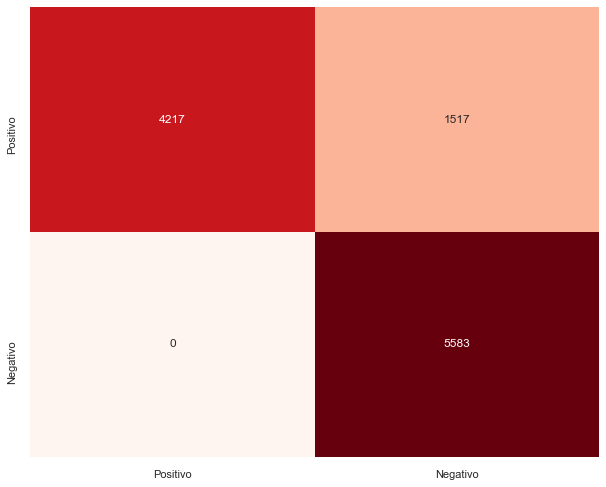

In [1444]:

# entropia_direto = [[3017, 513], [1200, 18085]]# sns.heatmap(entropia_direto, annot=True, cmap='Reds', cbar=False, fmt='d')
# # #####################################################################
# Gini_direto = [[3003, 509], [1214, 18089]]# sns.heatmap(Gini_direto, annot=True, cmap='Reds', cbar=False, fmt='d')

# #####################################################################
# entropia_primeiro = [[2964, 474], [1253, 18124]]# sns.heatmap(entropia_primeiro, annot=True, cmap='Reds', cbar=False, fmt='d')

# entropia_segundo = [[18083, 8], [41, 2956]]# sns.heatmap(entropia_segundo, annot=True, cmap='Reds', cbar=False, fmt='d')
# ########################################################################
# gini_primeiro = [[2948, 468], [1269, 18130]]# sns.heatmap(gini_primeiro, annot=True, cmap='Reds', cbar=False, fmt='d')

gini_segundo = [[4217, 1517], [0, 5583]]
sns.heatmap(gini_segundo, annot=True, cmap='Reds', cbar=False, fmt='d', xticklabels=['Positivo', 'Negativo'], yticklabels=['Positivo', 'Negativo'])